## Deep Learning Black-Scholes Formula - III

In [1]:
import numpy as np
import torch
import csv
import matplotlib.pyplot as plt

In [48]:
dataset = []
with open('../data/black_scholes_with_greeks.csv', newline='\n') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    dataset.append(row)

train_set, test_set = np.array(dataset[:16384], dtype=float), np.array(dataset[16384:], dtype=float)
train_features, train_labels = torch.from_numpy(train_set[:, 0:5]), torch.from_numpy(train_set[:, 5:])
test_features, test_labels = torch.from_numpy(test_set[:, 0:5]), torch.from_numpy(test_set[:, 5:])

In [49]:
batch_size = 256
train_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_features, train_labels),
                                         batch_size,
                                         shuffle=True)
test_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_features, test_labels),
                                        batch_size,
                                        shuffle=False)


In [50]:
num_inputs = 5
num_hidden = 20
num_outputs = 1

w1 = torch.nn.Parameter(torch.randn(num_inputs, num_hidden, requires_grad=True) * .1)
b1 = torch.nn.Parameter(torch.zeros(num_hidden, requires_grad=True))
w2 = torch.nn.Parameter(torch.randn(num_hidden, num_hidden, requires_grad=True) * .1)
b2 = torch.nn.Parameter(torch.zeros(num_hidden, requires_grad=True))
w3 = torch.nn.Parameter(torch.randn(num_hidden, num_hidden, requires_grad=True) * .1)
b3 = torch.nn.Parameter(torch.zeros(num_hidden, requires_grad=True))
w4 = torch.nn.Parameter(torch.randn(num_hidden, num_hidden, requires_grad=True) * .1)
b4 = torch.nn.Parameter(torch.zeros(num_hidden, requires_grad=True))
w5 = torch.nn.Parameter(torch.randn(num_hidden, num_outputs, requires_grad=True) * .1)
b5 = torch.nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [w1, b1, w2, b2, w3, b3, w4, b4, w5, b5]

class Model(torch.nn.Module):
  def __init__(self, params) -> None:
    super(Model, self).__init__()
    self.softplus = torch.nn.Softplus()
    self.sigmoid = torch.nn.Sigmoid()
    self.w1 = params[0]
    self.b1 = params[1]
    self.w2 = params[2]
    self.b2 = params[3]
    self.w3 = params[4]
    self.b3 = params[5]
    self.w4 = params[6]
    self.b4 = params[7]
    self.w5 = params[8]
    self.b5 = params[9]

  def forward(self, x):
    y1 = torch.matmul(self.softplus(x),  self.w1) + self.b1
    y2 = torch.matmul(self.softplus(y1), self.w2) + self.b2
    y3 = torch.matmul(self.softplus(y2), self.w3) + self.b3
    y4 = torch.matmul(self.softplus(y3), self.w4) + self.b4
    y5 = torch.matmul(self.softplus(y4), self.w5) + self.b5

    z5 = torch.ones_like(y5)
    z4 = torch.matmul(z5, torch.transpose(self.w5, 0, 1)) * self.sigmoid(y4)
    z3 = torch.matmul(z4, torch.transpose(self.w4, 0, 1)) * self.sigmoid(y3)
    z2 = torch.matmul(z3, torch.transpose(self.w3, 0, 1)) * self.sigmoid(y2)
    z1 = torch.matmul(z2, torch.transpose(self.w2, 0, 1)) * self.sigmoid(y1)
    z0 = torch.matmul(z1, torch.transpose(self.w1, 0, 1)) * self.sigmoid(x)

    return y5, z0

model = Model(params)

In [51]:
loss = torch.nn.MSELoss()

In [70]:
learning_rate = 0.0003
optimizer = torch.optim.Adam(params, lr=learning_rate)

In [73]:
num_epochs = 10
for epoch in range(num_epochs):
  for X, y in train_iter:
    val, deriv = model(X.float())
    l1 = loss(val, y.float()[:, 0].reshape(val.shape))
    l2 = loss(deriv, y.float()[:, 1:].reshape(deriv.shape))
    l = l1 + l2

    optimizer.zero_grad()
    l.backward()
    optimizer.step()

  val, deriv = model(train_features.float())
  l1 = loss(val, train_labels.float()[:, 0].reshape(val.shape))
  l2 = loss(deriv, train_labels.float()[:, 1:].reshape(deriv.shape))
  l = l1 + l2
  print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.044136
epoch 2, loss 0.043535
epoch 3, loss 0.047951
epoch 4, loss 0.049989
epoch 5, loss 0.041079
epoch 6, loss 0.046963
epoch 7, loss 0.041183
epoch 8, loss 0.041608
epoch 9, loss 0.045181
epoch 10, loss 0.042293


In [74]:
torch.save(model.state_dict(), '../save/black_scholes_greeks.ckpt')

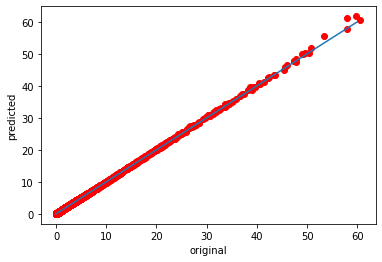

In [75]:
with torch.no_grad():
  val, deriv = model(train_features.float())
  predicted = val.numpy().reshape(-1)
  original = train_labels[:, 0].numpy().reshape(-1)

  plt.plot(original, predicted, 'ro')
  plt.xlabel("original")
  plt.ylabel("predicted")
  plt.plot([0, 60], [0, 60])
  plt.show()

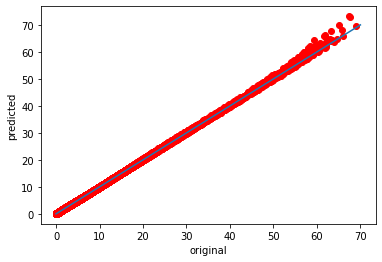

In [76]:
with torch.no_grad():
  val, deriv = model(test_features.float())
  predicted = val.numpy().reshape(-1)
  original = test_labels[:, 0].numpy().reshape(-1)

  plt.plot(original, predicted, 'ro')
  plt.xlabel("original")
  plt.ylabel("predicted")
  plt.plot([0, 70], [0, 70])
  plt.show()